In [1]:
# Library imports
import random

import torch
from torch import nn, optim
from torchvision import datasets
from torchvision import transforms
from torchvision.models.resnet import resnet18
from torch.utils.data import DataLoader

from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet

from skimage.color import rgb2lab, lab2rgb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
NET_IMG_SIZE = 256
LEARNING_RATE = 1e-3
BATCH_SIZE = 16

In [3]:
class VOCColorization(datasets.VOCDetection):
    def __init__(
        self, 
        root = 'data', 
        year = '2012', 
        image_set = 'train', 
        download = True, 
        transform = None, 
        target_transform = None, 
        transforms = None):

        super().__init__(root, year=year, image_set=image_set, download=download, transform=transform, target_transform=target_transform, transforms=transforms)

    def __getitem__(self, index):
        # For now we can discard the annotation/label, we can modify this method later should we need it
        # Note that the variable length of the annotations causes problems with the dataloader when retrieving
        # a batch
        target, label = super().__getitem__(index)

        lab_image = self.preprocess_image(target) # target is the original PIL RGB Image

        return lab_image, transforms.ToTensor()(target) 

    """
    Takes a PIL Image in RGB mode, resizes it to the globally defined NET_IMG_SIZE and transfers it to CIELab color space.
    Returns a tuple with two tensors, one for the L channel and one for the a and b channels together.

    """
    def preprocess_image(self, img):
        #resize_transform = transforms.Resize((NET_IMG_SIZE, NET_IMG_SIZE))

        #img = resize_transform(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Convert RGB to Lab color space
        img_lab = transforms.ToTensor()(img_lab)

        # Adjust all channels to range [-1,1]
        #img_lab[[0], ...] = img_lab[[0], ...] / 50. - 1. # L
        #img_lab[[1,2], ...] = img_lab[[1,2], ...] / 110. # ab

        return img_lab



In [4]:
# Download the Pascal VOC2012 datasets
# For now, we'll use the 'train' image subset as training data and 'val' as the testing set.
training_data = VOCColorization(
    'data', 
    year='2012', 
    image_set='train',
    transform=transforms.Resize((NET_IMG_SIZE, NET_IMG_SIZE)), 
    download=True)

test_data = VOCColorization(
    'data', 
    year='2012', 
    image_set='val',
    transform=transforms.Resize((NET_IMG_SIZE, NET_IMG_SIZE)),
    download=True)

print(f'Training dataset size = {len(training_data)}')
print(f'Testing dataset size = {len(test_data)}')

Using downloaded and verified file: data\VOCtrainval_11-May-2012.tar
Extracting data\VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data\VOCtrainval_11-May-2012.tar
Extracting data\VOCtrainval_11-May-2012.tar to data
Training dataset size = 5717
Testing dataset size = 5823


lab_img = torch.Size([3, 256, 256])
rgb_img=torch.Size([3, 256, 256])
tensor([[44.5738, 44.6067, 45.6641,  ..., 52.8107, 32.5519, 24.5661],
        [45.7619, 44.4667, 44.7178,  ..., 58.8239, 43.6387, 35.1165],
        [45.9942, 42.5153, 42.3633,  ..., 56.9099, 49.6205, 42.3133],
        ...,
        [33.6388, 36.0314, 35.9575,  ...,  0.2940,  0.0000,  0.0000],
        [30.8986, 31.6879, 32.6285,  ...,  0.0000,  0.0000,  0.0000],
        [31.4553, 31.3190, 31.2375,  ...,  0.0000,  0.0000,  0.0000]])


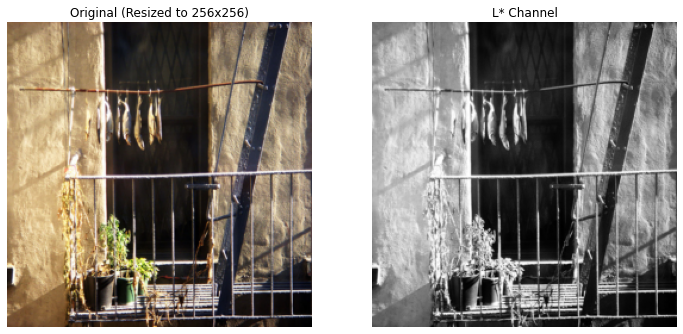

In [5]:
# Sample code to visualize random Colorization dataset images
lab_img, rgb_img = training_data[random.randint(0, len(training_data))]
print(f'lab_img = {lab_img.shape}\nrgb_img={rgb_img.shape}')

# Slice off L and ab channels
L = lab_img[[0], ...]
ab = lab_img[[1,2], ...]

# Convert from 1xHxW array to HxW so we can display it with PyPlot
new_L = L[0, :, :]
print(new_L)

# Display our images using pyplot
rows, cols = 1, 2
fig = plt.figure(figsize=(12,12))

fig.add_subplot(rows, cols, 1)
plt.title(f'Original (Resized to {NET_IMG_SIZE}x{NET_IMG_SIZE})')
plt.axis("off")
plt.imshow(transforms.ToPILImage()(rgb_img))

fig.add_subplot(rows, cols, 2)
plt.title('L* Channel')
plt.axis("off")
plt.imshow(new_L, cmap='gray')

plt.show()

In [6]:
# Create dataloaders for our datasets
training_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
lab_img, rgb_img = next(iter(training_dataloader))

print(f'lab_img.shape = {lab_img.shape}\nrgb_img.shape = {rgb_img.shape}')
print(f'lab_img = {lab_img}\n')
print(f'rgb_img = {rgb_img}')

lab_img.shape = torch.Size([16, 3, 256, 256])
rgb_img.shape = torch.Size([16, 3, 256, 256])
lab_img = tensor([[[[ 9.7926e+01,  9.7579e+01,  9.8272e+01,  ...,  9.3924e+01,
            9.4150e+01,  9.4672e+01],
          [ 9.7579e+01,  9.7579e+01,  9.7926e+01,  ...,  9.4946e+01,
            8.9069e+01,  7.5656e+01],
          [ 9.7876e+01,  9.7926e+01,  9.8272e+01,  ...,  6.6922e+01,
            5.5009e+01,  6.7284e+01],
          ...,
          [ 7.7295e+01,  8.0504e+01,  7.9455e+01,  ...,  5.7908e+01,
            5.5031e+01,  5.3332e+01],
          [ 6.6650e+01,  7.8720e+01,  8.0148e+01,  ...,  4.7758e+01,
            5.7126e+01,  5.4728e+01],
          [ 7.2370e+01,  8.0025e+01,  8.3409e+01,  ...,  2.3972e+01,
            3.5953e+01,  6.5565e+01]],

         [[-2.4110e-03, -2.4037e-03, -2.4184e-03,  ...,  4.7043e-01,
           -2.1052e-01, -8.7855e-01],
          [-2.4037e-03, -2.4037e-03, -2.4110e-03,  ...,  4.7608e-01,
           -4.1071e+00, -3.2220e+00],
          [-3.5256e-01, -

In [8]:
body = create_body(resnet18, pretrained=True, n_in=1, cut=-2)
model = DynamicUnet(body, n_out=2, img_size=(NET_IMG_SIZE, NET_IMG_SIZE))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(model)
model.to(device)

C:\Users\davva\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [11]:
# Test to ensure that our model accepts inputs and returns outputs of the correct shape
lab_img, rgb_img = next(iter(training_dataloader))

L_channel = lab_img[:,[0], ...]
ab_channels = lab_img[:,[1,2], ...]

print(f'L_channel.shape = {L_channel.shape}\n')
print(f'ab_channel.shape = {ab_channels.shape}\n')


with torch.no_grad():
    L_channel = L_channel.to(device)

    ab_hat = model(L_channel)

    print(f'ab_hat = {ab_hat.shape}')


L_channel.shape = torch.Size([16, 1, 256, 256])

ab_channel.shape = torch.Size([16, 2, 256, 256])

ab_hat = torch.Size([16, 2, 256, 256])
